In [37]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
shots = 10_000

## a)

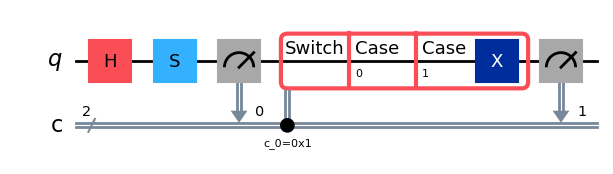

In [38]:
qc = QuantumCircuit(1,2)
qc.h(0)
qc.s(0)
qc.measure(0,0)
with qc.switch(0) as case:
    with case(0):
        pass
    with case(1):
        qc.x(0)
qc.measure(0,1)
qc.draw('mpl')

In [39]:
# copied from Ex. 3
def find_ev(results, segment):
    numplus = 0
    for name, counts in results.items():
        parity = 0
        for letter in name[segment[0]:segment[1]]:
            if letter == "1":
                parity += 1
        if parity % 2 == 0:
            numplus += counts
    return (2*numplus/shots-1)

{'00': 5025, '01': 4975}
EV: 1.0


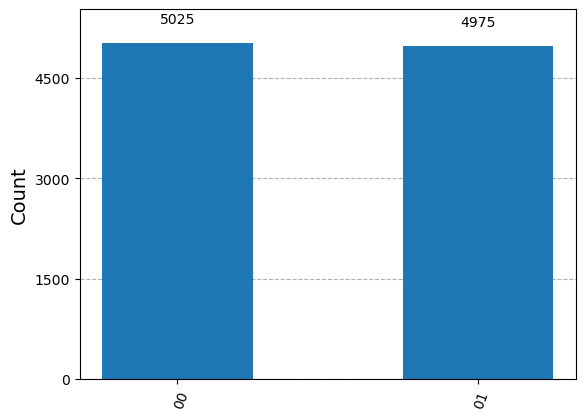

In [40]:
simu = AerSimulator()
result = simu.run(qc, shots=shots).result().get_counts()
print(result)
print("EV: " + str(find_ev(result, (0,1))))
plot_histogram(result)
# As we can see measuring the qubit at the end of the circuit in Z 
# basis always yields measurement result +1

## b)

{'00': 4967, '01': 5033}
EV: 1.0


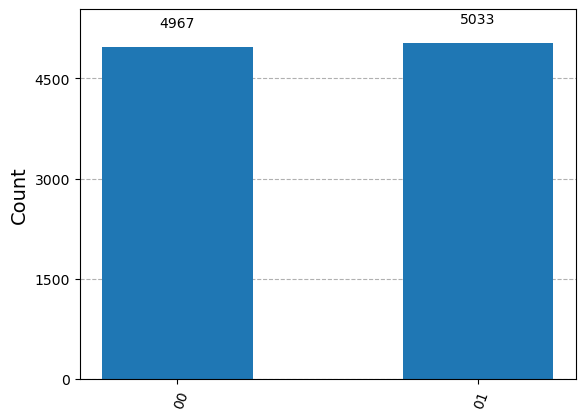

In [41]:
def make_bell_state(m):
    qc = QuantumCircuit(3,2)
    for _ in range(m):
        # x error on qubit 1
        qc.x(0)
        # S1 measurement
        qc.cx(0,2)
        qc.cx(1,2)
        qc.measure(2,0)
        # reset ancilla and apply correction
        with qc.switch(0) as case:
            with case(1):
                qc.x(2)
                qc.z(0)
                
        # S2 measurement
        qc.h(2)
        qc.cz(2,0)
        qc.cz(2,1)
        qc.h(2)
        qc.measure(2,1)
        # reset ancilla and apply correction
        with qc.switch(1) as case:
            with case(1):
                qc.x(2)
                qc.x(0)
    return qc
        
bell = make_bell_state(1)
bell.draw('mpl')
result = simu.run(qc, shots=shots).result().get_counts()
print(result)
print("EV: " + str(find_ev(result, (0,1))))
plot_histogram(result)
    
    

In [42]:
from qiskit_ibm_provider import IBMProvider

file_token = open("ibm_token_felix.txt")
token = file_token.read()
file_token.close()

IBMProvider.save_account(overwrite=True, token=token)
provider = IBMProvider()

name = 'ibm_sherbrooke'
backend = provider.get_backend(name)


In [43]:
circs = []
for m in [1,2,3,10,20]:
    for i in range(3):
        qc = make_bell_state(m)
        if i == 0:
            # ZZ measurement
            qc.cx(0,2)
            qc.cx(1,2)
            # we measure everything to classical bit 1
            qc.measure(2,0)
            circs.append(qc)
        if i == 1:
            # XX measurement
            qc.h(2)
            qc.cz(0,2)
            qc.cz(1,2)
            qc.h(2)
            qc.measure(2,0)
            circs.append(qc)
        if i == 2:
            # YY measurement
            qc.cx(0,2)
            qc.cx(1,2)
            qc.h(2)
            qc.cz(0,2)
            qc.cz(1,2)
            qc.h(2)
            qc.measure(2,0)
            circs.append(qc)

In [44]:
from qiskit import transpile
real_circs = []
for qc in circs:
        qc_real = transpile(qc, backend=backend)
        real_circs.append(qc_real)
backend

<IBMBackend('ibm_sherbrooke')>

In [45]:
print(f'Submit all {len(real_circs)} circuits to '+name)
job = backend.run(real_circs, shots = 10_000)
job.job_id()

Submit all 15 circuits to ibm_sherbrooke


'csasbs7tg3bg008zxm9g'

In [ ]:
# Unfortunately, I did not have the time to analyse the job's empiric results.